In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from PIL import Image
import math
import itertools

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.nn.functional as F

from itertools import count
from collections import defaultdict

import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE

import scipy.io

In [2]:
USE_CUDA = True
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 100
z_dim = 128
test_path = '/home/irfandw/Works/dataset/morph/image_1/'

In [3]:
test_dataset = ImageFolder(
        root=test_path,
        transform=torchvision.transforms.ToTensor()
    )
test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [4]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[3,4,6,3], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[3,4,6,3], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

class WAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self._encode(x)
        
        x_recon = self._decode(z)
        return x_recon, z

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, x):
        return self.decoder(x)


class Adversary(nn.Module):
    def __init__(self, z_dim):
        super(Adversary, self).__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),                                
            nn.ReLU(True),
            nn.Linear(512, 512),                                  
            nn.ReLU(True),
            nn.Linear(512, 512),                                 
            nn.ReLU(True),
            nn.Linear(512, 512),                                 
            nn.ReLU(True),
            nn.Linear(512, 1),                                   
        )

    def forward(self, z):
        return self.net(z)

In [5]:
WAE_net = WAE(z_dim=128)
#discriminator = Adversary(z_dim=128)

if torch.cuda.is_available():
    WAE_net = WAE_net.cuda()

In [6]:
WAE_net.load_state_dict(torch.load('saved_model_x4/WAE.pth'))
#discriminator.load_state_dict(torch.load('saved_model_x4/discriminator_.pth'))

## Generate Images part

In [7]:
WAE_net.eval()

batchz = 100

genz = []

with torch.no_grad():
    for i in range(10):
        zx = torch.randn(batchz, z_dim)
        
        zx = zx.to(device)
        
        gen = WAE_net._decode(zx)

        genz.append(gen[0].cpu().numpy())

genz = np.array(genz)
genz = np.transpose(genz, (0, 2,3,1))

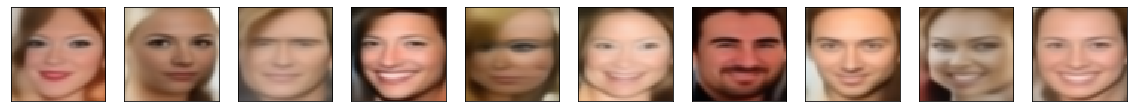

In [8]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(genz[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


## Autoencoder part

In [9]:
WAE_net.eval()

recons_images = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = WAE_net._encode(datax)
        print(z_encoded.size())
        decod = WAE_net._decode(z_encoded)

        recons_images.append(decod[0].cpu().numpy())

recons_images = np.array(recons_images)
recons_images = np.transpose(recons_images, (0, 2,3,1))

torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])


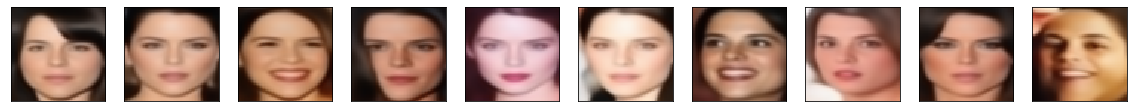

In [10]:
plt.figure(figsize=(20, 4))


for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(recons_images[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.savefig('result/01-wae_128_recons_1.jpg', dpi=300, bbox_inches = 'tight')


## Morph

In [11]:
path_image1 = '/home/irfandw/Works/dataset/morph/image_1/'

path_image2 = '/home/irfandw/Works/dataset/morph/image_2/'


test_dataset1 = ImageFolder(
        root=path_image1,
        transform=torchvision.transforms.ToTensor()
    )
test_loader1 = DataLoader(
        test_dataset1,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )


test_dataset2 = ImageFolder(
        root=path_image2,
        transform=torchvision.transforms.ToTensor()
    )
test_loader2 = DataLoader(
        test_dataset2,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [12]:
WAE_net.eval()


z1 = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader1):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = WAE_net._encode(datax)
        z1.append(z_encoded[0].cpu().numpy())

z1 = np.array(z1)

In [13]:
WAE_net.eval()

z2 = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader2):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = WAE_net._encode(datax)
        z2.append(z_encoded[0].cpu().numpy())

z2 = np.array(z2)

In [14]:
WAE_net.eval()

d_morph = []

with torch.no_grad():
    for i,a in enumerate(np.linspace(0,1,10)):
        z_new = z1[0] * (1. - a) + z2[3] * a
        
        z_new = z_new[np.newaxis,:]
        
        zx = torch.from_numpy(z_new)
        zx = zx.to(device)
        
        #print(zx.size(0))
        gen = WAE_net._decode(zx)

        d_morph.append(gen[0].cpu().numpy())

d_morph = np.array(d_morph)
d_morph = np.transpose(d_morph, (0, 2,3,1))

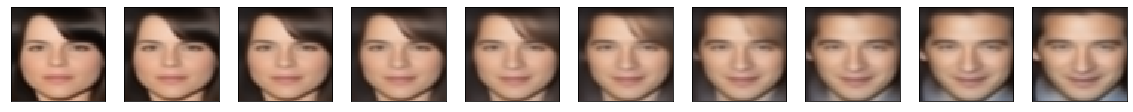

In [15]:
plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(d_morph[i])
    
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #plt.savefig('result/03-morph_resnetwae_128.jpg', dpi=300, bbox_inches = 'tight')

## TSNE

In [16]:
tsne_path = '/home/irfandw/Works/dataset/tsne/'

In [17]:
tsne_dataset = ImageFolder(
        root=tsne_path,
        transform=torchvision.transforms.ToTensor()
    )
tsne_loader = DataLoader(
        tsne_dataset,
        batch_size=1,
        num_workers=2,
        shuffle=False
    )

In [18]:
def load_name(path):
    all_names = []
    all_index =  []    
    
    for root, dirs, files in os.walk(path):
        all_index.append(os.path.basename(root))
        dirs.sort()
        for file_ in files:
            all_names.append(os.path.basename(root))
                
    return all_names, all_index

all_names, indexing = load_name(tsne_path)

In [19]:
all_names

['Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',
 'Abigail_Breslin',


In [20]:
d = defaultdict(count().__next__)

new_list = [d[x] for x in all_names]

new_list =  np.array(new_list)

In [21]:
WAE_net.eval()

z_tsne = []

with torch.no_grad():
    for batch_idx, data in enumerate(tsne_loader):
        datax,_ = data
        datax = datax.to(device)

        z_encoded = WAE_net._encode(datax)
        z_tsne.append(z_encoded[0].cpu().numpy())

z_tsne = np.array(z_tsne)

In [22]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=30, n_iter=2000)

In [23]:
X_2d = tsne.fit_transform(z_tsne)

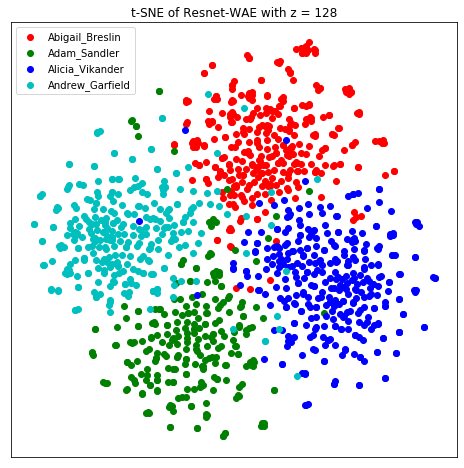

In [24]:
target_ids = range(len(indexing[1:]))

plt.figure(figsize=(8,8))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'brown', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, indexing[1:]):
    plt.scatter(X_2d[new_list == i, 0], X_2d[new_list == i, 1], c=c, label=label)


plt.title('t-SNE of Resnet-WAE with z = 128')      
plt.xticks([], [])
plt.yticks([], [])
plt.legend(loc="upper left")
#plt.savefig('result/04-Resnet_WAE_128_TSNE.jpg', dpi=300, bbox_inches = 'tight')
plt.show()